In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'
                   ])
len(ondate_cols)

28

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l2_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(5803, 1, 28) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 252) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.783712
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.774403
[3]	valid_0's rmse: 0.765348
[4]	valid_0's rmse: 0.756588
[5]	valid_0's rmse: 0.748082
[6]	valid_0's rmse: 0.739803
[7]	valid_0's rmse: 0.731725
[8]	valid_0's rmse: 0.723921
[9]	valid_0's rmse: 0.716358
[10]	valid_0's rmse: 0.708979
[11]	valid_0's rmse: 0.701859
[12]	valid_0's rmse: 0.694911
[13]	valid_0's rmse: 0.688286
[14]	valid_0's rmse: 0.681762
[15]	valid_0's rmse: 0.675451
[16]	valid_0's rmse: 0.66934
[17]	valid_0's rmse: 0.663397
[18]	valid_0's rmse: 0.657645
[19]	valid_0's rmse: 0.652074
[20]	valid_0's rmse: 0.646664
[21]	valid_0's rmse: 0.641402
[22]	valid_0's rmse: 0.636325
[23]	valid_0's rmse: 0.63153
[24]	valid_0's rmse: 0.626824
[25]	valid_0's rmse: 0.622198
[26]	valid_0's rmse: 0.617727
[27]	valid_0's rmse: 0.613393
[28]	valid_0's rmse: 0.609193
[29]	valid_0's rmse: 0.605155
[30]	valid_0's rmse: 0.60124
[31]	valid_0's rmse: 0.597486
[32]	valid_0's rmse:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911475  0.017635  0.218019    7  2017-04-16
472     2.507290  2.540177 -0.032886  0.216005    1  2017-04-17
473     2.661330  2.658303  0.003027  0.243467    2  2017-04-18
474     2.754815  2.750996  0.003819  0.200543    3  2017-04-19
475     2.713762  2.718934 -0.005172  0.227496    4  2017-04-20
476     2.999000  2.990394  0.008605  0.149827    5  2017-04-21
477     3.075529  3.093009 -0.017480  0.177655    6  2017-04-22

0.204716058749


pred         y     error    error2  day        date
dayidx                                                         
471     2.911475  2.929110  0.017635  0.218019    7  2017-04-16
472     2.540177  2.507290 -0.032886  0.216005    1  2017-04-17
473     2.658303  2.661330  0.003027  0.243467    2  2017-04-18
474     2.750996  2.754815  0.003819  0.200543    3  2017-04-19
475     2.718934  2.713762 -0.005172  0.227496    4  2017-04-20
476     2.990394  2.999000  0.008605  0.149827    5  2017-04-21
477     3.093009  3.075529 -0.017480  0.177655    6  2017-04-22

(829, 252)


2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(6632, 1, 28) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 252) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.492349
[236]	valid_0's rmse: 0.492359
[237]	valid_0's rmse: 0.492382
[238]	valid_0's rmse: 0.492387
[239]	valid_0's rmse: 0.492408
[240]	valid_0's rmse: 0.492403
[241]	valid_0's rmse: 0.492427
[242]	valid_0's rmse: 0.492432
[243]	valid_0's rmse: 0.492432
[244]	valid_0's rmse: 0.492449
[245]	valid_0's rmse: 0.492445
[246]	valid_0's rmse: 0.492439
[247]	valid_0's rmse: 0.492442
[248]	valid_0's rmse: 0.492437
[249]	valid_0's rmse: 0.492422
[250]	valid_0's rmse: 0.492416
[251]	valid_0's rmse: 0.492429
[252]	valid_0's rmse: 0.492435
[253]	valid_0's rmse: 0.492447
[254]	valid_0's rmse: 0.492454
[255]	valid_0's rmse: 0.492474
[256]	valid_0's rmse: 0.492475
[257]	valid_0's rmse: 0.492488
[258]	valid_0's rmse: 0.492488
[259]	valid_0's rmse: 0.492495
[260]	valid_0's rmse: 0.492482
Early stopping, best iteration is:
[210]	valid_0's rmse: 0.492231
0.2218096599186438 0.24229172606296995
[0.24229172606296995]
-1 mean score 0.24229172606296995
0.280378316651


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928051  0.001059  0.268638    7  2017-04-16
472     2.507290  2.605547 -0.098257  0.413866    1  2017-04-17
473     2.661330  2.729429 -0.068099  0.338799    2  2017-04-18
474     2.754815  2.768546 -0.013731  0.245105    3  2017-04-19
475     2.713762  2.745125 -0.031364  0.284981    4  2017-04-20
476     2.999000  3.016225 -0.017225  0.198030    5  2017-04-21
477     3.075529  3.087335 -0.011806  0.213229    6  2017-04-22

0.280378316651


pred         y     error    error2  day        date
dayidx                                                         
471     2.928051  2.929110  0.001059  0.268638    7  2017-04-16
472     2.605547  2.507290 -0.098257  0.413866    1  2017-04-17
473     2.729429  2.661330 -0.068099  0.338799    2  2017-04-18
474     2.768546  2.754815 -0.013731  0.245105    3  2017-04-19
475     2.745125  2.713762 -0.031364  0.284981    4  2017-04-20
476     3.016225  2.999000 -0.017225  0.198030    5  2017-04-21
477     3.087335  3.075529 -0.011806  0.213229    6  2017-04-22

(829, 252)


3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(7461, 1, 28) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 252) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.496107
[236]	valid_0's rmse: 0.496111
[237]	valid_0's rmse: 0.496122
[238]	valid_0's rmse: 0.496128
[239]	valid_0's rmse: 0.496132
[240]	valid_0's rmse: 0.496129
[241]	valid_0's rmse: 0.49614
[242]	valid_0's rmse: 0.496155
[243]	valid_0's rmse: 0.496168
[244]	valid_0's rmse: 0.49616
[245]	valid_0's rmse: 0.496167
[246]	valid_0's rmse: 0.496175
[247]	valid_0's rmse: 0.496181
[248]	valid_0's rmse: 0.496177
[249]	valid_0's rmse: 0.496175
[250]	valid_0's rmse: 0.496174
[251]	valid_0's rmse: 0.496189
[252]	valid_0's rmse: 0.496177
[253]	valid_0's rmse: 0.496183
[254]	valid_0's rmse: 0.496187
[255]	valid_0's rmse: 0.496184
[256]	valid_0's rmse: 0.496183
[257]	valid_0's rmse: 0.49619
[258]	valid_0's rmse: 0.496191
[259]	valid_0's rmse: 0.496193
[260]	valid_0's rmse: 0.496212
[261]	valid_0's rmse: 0.496218
[262]	valid_0's rmse: 0.496234
[263]	valid_0's rmse: 0.496239
[264]	valid_0's rmse: 0.496235
[265]	valid_0's rmse: 0.496249
[266]	valid_0's rmse: 0.496251
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895065  0.034045  0.245434    7  2017-04-16
472     2.507290  2.572538 -0.065248  0.289214    1  2017-04-17
473     2.661330  2.678329 -0.016999  0.403958    2  2017-04-18
474     2.754815  2.792804 -0.037989  0.331001    3  2017-04-19
475     2.713762  2.744250 -0.030488  0.298308    4  2017-04-20
476     2.999000  2.987789  0.011211  0.187005    5  2017-04-21
477     3.075529  3.077141 -0.001612  0.249708    6  2017-04-22

0.286375362717


pred         y     error    error2  day        date
dayidx                                                         
471     2.895065  2.929110  0.034045  0.245434    7  2017-04-16
472     2.572538  2.507290 -0.065248  0.289214    1  2017-04-17
473     2.678329  2.661330 -0.016999  0.403958    2  2017-04-18
474     2.792804  2.754815 -0.037989  0.331001    3  2017-04-19
475     2.744250  2.713762 -0.030488  0.298308    4  2017-04-20
476     2.987789  2.999000  0.011211  0.187005    5  2017-04-21
477     3.077141  3.075529 -0.001612  0.249708    6  2017-04-22

(829, 252)


4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(8290, 1, 28) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 252) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.497368
[236]	valid_0's rmse: 0.49736
[237]	valid_0's rmse: 0.497356
[238]	valid_0's rmse: 0.49737
[239]	valid_0's rmse: 0.497374
[240]	valid_0's rmse: 0.497382
[241]	valid_0's rmse: 0.497392
[242]	valid_0's rmse: 0.49739
[243]	valid_0's rmse: 0.497384
[244]	valid_0's rmse: 0.497399
[245]	valid_0's rmse: 0.497403
[246]	valid_0's rmse: 0.497428
[247]	valid_0's rmse: 0.497437
[248]	valid_0's rmse: 0.497441
[249]	valid_0's rmse: 0.497449
[250]	valid_0's rmse: 0.49745
[251]	valid_0's rmse: 0.497456
[252]	valid_0's rmse: 0.497476
[253]	valid_0's rmse: 0.497479
[254]	valid_0's rmse: 0.497485
[255]	valid_0's rmse: 0.497473
[256]	valid_0's rmse: 0.497487
[257]	valid_0's rmse: 0.497493
[258]	valid_0's rmse: 0.497495
[259]	valid_0's rmse: 0.497502
[260]	valid_0's rmse: 0.497519
[261]	valid_0's rmse: 0.497517
[262]	valid_0's rmse: 0.497527
[263]	valid_0's rmse: 0.497534
[264]	valid_0's rmse: 0.497531
[265]	valid_0's rmse: 0.497537
Early stopping, best iteration is:
[215]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890672  0.038438  0.305368    7  2017-04-16
472     2.507290  2.551892 -0.044602  0.251934    1  2017-04-17
473     2.661330  2.679099 -0.017769  0.284891    2  2017-04-18
474     2.754815  2.723454  0.031361  0.375374    3  2017-04-19
475     2.713762  2.769956 -0.056194  0.343576    4  2017-04-20
476     2.999000  2.991402  0.007598  0.211101    5  2017-04-21
477     3.075529  3.043073  0.032456  0.255488    6  2017-04-22

0.289676043145


pred         y     error    error2  day        date
dayidx                                                         
471     2.890672  2.929110  0.038438  0.305368    7  2017-04-16
472     2.551892  2.507290 -0.044602  0.251934    1  2017-04-17
473     2.679099  2.661330 -0.017769  0.284891    2  2017-04-18
474     2.723454  2.754815  0.031361  0.375374    3  2017-04-19
475     2.769956  2.713762 -0.056194  0.343576    4  2017-04-20
476     2.991402  2.999000  0.007598  0.211101    5  2017-04-21
477     3.043073  3.075529  0.032456  0.255488    6  2017-04-22

(829, 252)


5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(9119, 1, 28) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 252) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.499643
[237]	valid_0's rmse: 0.499633
[238]	valid_0's rmse: 0.499642
[239]	valid_0's rmse: 0.499651
[240]	valid_0's rmse: 0.499644
[241]	valid_0's rmse: 0.499638
[242]	valid_0's rmse: 0.499639
[243]	valid_0's rmse: 0.499656
Early stopping, best iteration is:
[193]	valid_0's rmse: 0.499541
0.22967963685413156 0.2495414998136596
[0.2495414998136596]
-1 mean score 0.2495414998136596
0.296495704483


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870593  0.058517  0.340131    7  2017-04-16
472     2.507290  2.555510 -0.048220  0.275918    1  2017-04-17
473     2.661330  2.666506 -0.005176  0.273100    2  2017-04-18
474     2.754815  2.755919 -0.001105  0.255262    3  2017-04-19
475     2.713762  2.713763 -0.000002  0.390739    4  2017-04-20
476     2.999000  2.981022  0.017977  0.276365    5  2017-04-21
477     3.075529  3.048560  0.026969  0.263955    6  2017-04-22

0.296495704483


pred         y     error    error2  day        date
dayidx                                                         
471     2.870593  2.929110  0.058517  0.340131    7  2017-04-16
472     2.555510  2.507290 -0.048220  0.275918    1  2017-04-17
473     2.666506  2.661330 -0.005176  0.273100    2  2017-04-18
474     2.755919  2.754815 -0.001105  0.255262    3  2017-04-19
475     2.713763  2.713762 -0.000002  0.390739    4  2017-04-20
476     2.981022  2.999000  0.017977  0.276365    5  2017-04-21
477     3.048560  3.075529  0.026969  0.263955    6  2017-04-22

(829, 252)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(9948, 1, 28) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 252) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.500235
[236]	valid_0's rmse: 0.500236
[237]	valid_0's rmse: 0.500243
[238]	valid_0's rmse: 0.500249
[239]	valid_0's rmse: 0.500251
[240]	valid_0's rmse: 0.500252
[241]	valid_0's rmse: 0.500257
[242]	valid_0's rmse: 0.500259
[243]	valid_0's rmse: 0.500258
[244]	valid_0's rmse: 0.500253
[245]	valid_0's rmse: 0.500264
[246]	valid_0's rmse: 0.500279
[247]	valid_0's rmse: 0.500282
[248]	valid_0's rmse: 0.500287
[249]	valid_0's rmse: 0.500295
[250]	valid_0's rmse: 0.500302
[251]	valid_0's rmse: 0.500303
[252]	valid_0's rmse: 0.500314
[253]	valid_0's rmse: 0.500319
[254]	valid_0's rmse: 0.500325
[255]	valid_0's rmse: 0.500335
[256]	valid_0's rmse: 0.500338
[257]	valid_0's rmse: 0.50034
[258]	valid_0's rmse: 0.500341
[259]	valid_0's rmse: 0.500344
[260]	valid_0's rmse: 0.500354
[261]	valid_0's rmse: 0.500363
[262]	valid_0's rmse: 0.500363
[263]	valid_0's rmse: 0.500367
[264]	valid_0's rmse: 0.500358
[265]	valid_0's rmse: 0.500356
[266]	valid_0's rmse: 0.500355
Early sto

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895091  0.034019  0.338365    7  2017-04-16
472     2.507290  2.579312 -0.072022  0.309348    1  2017-04-17
473     2.661330  2.675226 -0.013896  0.298547    2  2017-04-18
474     2.754815  2.755667 -0.000852  0.229757    3  2017-04-19
475     2.713762  2.731691 -0.017929  0.276184    4  2017-04-20
476     2.999000  2.911480  0.087519  0.349000    5  2017-04-21
477     3.075529  3.037224  0.038305  0.348334    6  2017-04-22

0.307076417353


pred         y     error    error2  day        date
dayidx                                                         
471     2.895091  2.929110  0.034019  0.338365    7  2017-04-16
472     2.579312  2.507290 -0.072022  0.309348    1  2017-04-17
473     2.675226  2.661330 -0.013896  0.298547    2  2017-04-18
474     2.755667  2.754815 -0.000852  0.229757    3  2017-04-19
475     2.731691  2.713762 -0.017929  0.276184    4  2017-04-20
476     2.911480  2.999000  0.087519  0.349000    5  2017-04-21
477     3.037224  3.075529  0.038305  0.348334    6  2017-04-22

(829, 252)


7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 16.310143
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(10777, 1, 28) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 252) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.498469
[236]	valid_0's rmse: 0.498467
[237]	valid_0's rmse: 0.498471
[238]	valid_0's rmse: 0.498476
[239]	valid_0's rmse: 0.498485
[240]	valid_0's rmse: 0.498494
[241]	valid_0's rmse: 0.498497
[242]	valid_0's rmse: 0.498509
[243]	valid_0's rmse: 0.498523
[244]	valid_0's rmse: 0.498524
[245]	valid_0's rmse: 0.498531
[246]	valid_0's rmse: 0.498529
[247]	valid_0's rmse: 0.498548
[248]	valid_0's rmse: 0.498545
[249]	valid_0's rmse: 0.49855
[250]	valid_0's rmse: 0.498536
[251]	valid_0's rmse: 0.498531
[252]	valid_0's rmse: 0.498531
[253]	valid_0's rmse: 0.498529
[254]	valid_0's rmse: 0.498527
[255]	valid_0's rmse: 0.49854
[256]	valid_0's rmse: 0.498549
[257]	valid_0's rmse: 0.498558
[258]	valid_0's rmse: 0.498568
[259]	valid_0's rmse: 0.498569
[260]	valid_0's rmse: 0.498574
[261]	valid_0's rmse: 0.498593
[262]	valid_0's rmse: 0.4986
[263]	valid_0's rmse: 0.498616
[264]	valid_0's rmse: 0.498621
[265]	valid_0's rmse: 0.498624
[266]	valid_0's rmse: 0.49864
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902456  0.026654  0.354575    7  2017-04-16
472     2.507290  2.592092 -0.084802  0.307767    1  2017-04-17
473     2.661330  2.691736 -0.030407  0.317025    2  2017-04-18
474     2.754815  2.758196 -0.003381  0.255545    3  2017-04-19
475     2.713762  2.732349 -0.018587  0.264982    4  2017-04-20
476     2.999000  2.996964  0.002035  0.197380    5  2017-04-21
477     3.075529  3.105037 -0.029508  0.326391    6  2017-04-22

0.289095055702


pred         y     error    error2  day        date
dayidx                                                         
471     2.902456  2.929110  0.026654  0.354575    7  2017-04-16
472     2.592092  2.507290 -0.084802  0.307767    1  2017-04-17
473     2.691736  2.661330 -0.030407  0.317025    2  2017-04-18
474     2.758196  2.754815 -0.003381  0.255545    3  2017-04-19
475     2.732349  2.713762 -0.018587  0.264982    4  2017-04-20
476     2.996964  2.999000  0.002035  0.197380    5  2017-04-21
477     3.105037  3.075529 -0.029508  0.326391    6  2017-04-22

(829, 252)


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(11606, 1, 28) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 252) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.22887062987567236 0.24427805216988582
[0.24427805216988582]
-1 mean score 0.24427805216988582
0.281071359203


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.992857 -0.063747  0.362542    7  2017-04-16
472     2.507290  2.618357 -0.111066  0.332750    1  2017-04-17
473     2.661330  2.689635 -0.028306  0.296639    2  2017-04-18
474     2.754815  2.783187 -0.028372  0.288005    3  2017-04-19
475     2.713762  2.743367 -0.029606  0.288651    4  2017-04-20
476     2.999000  2.979890  0.019109  0.170804    5  2017-04-21
477     3.075529  3.111380 -0.035851  0.228109    6  2017-04-22

0.281071359203


pred         y     error    error2  day        date
dayidx                                                         
471     2.992857  2.929110 -0.063747  0.362542    7  2017-04-16
472     2.618357  2.507290 -0.111066  0.332750    1  2017-04-17
473     2.689635  2.661330 -0.028306  0.296639    2  2017-04-18
474     2.783187  2.754815 -0.028372  0.288005    3  2017-04-19
475     2.743367  2.713762 -0.029606  0.288651    4  2017-04-20
476     2.979890  2.999000  0.019109  0.170804    5  2017-04-21
477     3.111380  3.075529 -0.035851  0.228109    6  2017-04-22

(829, 252)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(12435, 1, 28) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 252) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.501613
[237]	valid_0's rmse: 0.501609
[238]	valid_0's rmse: 0.501607
[239]	valid_0's rmse: 0.501608
[240]	valid_0's rmse: 0.5016
[241]	valid_0's rmse: 0.501607
[242]	valid_0's rmse: 0.501606
[243]	valid_0's rmse: 0.501626
[244]	valid_0's rmse: 0.501635
[245]	valid_0's rmse: 0.501642
Early stopping, best iteration is:
[195]	valid_0's rmse: 0.501491
0.23231017503935356 0.25149302540210633
[0.25149302540210633]
-1 mean score 0.25149302540210633
0.295970551119


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921436  0.007674  0.271818    7  2017-04-16
472     2.507290  2.623229 -0.115939  0.423808    1  2017-04-17
473     2.661330  2.738343 -0.077013  0.378042    2  2017-04-18
474     2.754815  2.767210 -0.012395  0.271158    3  2017-04-19
475     2.713762  2.751638 -0.037877  0.308799    4  2017-04-20
476     2.999000  2.987911  0.011089  0.200545    5  2017-04-21
477     3.075529  3.091251 -0.015721  0.217624    6  2017-04-22

0.295970551119


pred         y     error    error2  day        date
dayidx                                                         
471     2.921436  2.929110  0.007674  0.271818    7  2017-04-16
472     2.623229  2.507290 -0.115939  0.423808    1  2017-04-17
473     2.738343  2.661330 -0.077013  0.378042    2  2017-04-18
474     2.767210  2.754815 -0.012395  0.271158    3  2017-04-19
475     2.751638  2.713762 -0.037877  0.308799    4  2017-04-20
476     2.987911  2.999000  0.011089  0.200545    5  2017-04-21
477     3.091251  3.075529 -0.015721  0.217624    6  2017-04-22

(829, 252)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(13264, 1, 28) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 252) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.504648
[235]	valid_0's rmse: 0.504655
[236]	valid_0's rmse: 0.504653
[237]	valid_0's rmse: 0.504647
[238]	valid_0's rmse: 0.504648
[239]	valid_0's rmse: 0.504652
[240]	valid_0's rmse: 0.504664
Early stopping, best iteration is:
[190]	valid_0's rmse: 0.504463
0.2359682117585636 0.2544825299558866
[0.2544825299558866]
-1 mean score 0.2544825299558866
0.289937896014


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904550  0.024560  0.264234    7  2017-04-16
472     2.507290  2.570714 -0.063423  0.277548    1  2017-04-17
473     2.661330  2.686956 -0.025627  0.401368    2  2017-04-18
474     2.754815  2.790785 -0.035970  0.332480    3  2017-04-19
475     2.713762  2.754317 -0.040555  0.293023    4  2017-04-20
476     2.999000  2.977750  0.021250  0.210749    5  2017-04-21
477     3.075529  3.074506  0.001023  0.250162    6  2017-04-22

0.289937896014


pred         y     error    error2  day        date
dayidx                                                         
471     2.904550  2.929110  0.024560  0.264234    7  2017-04-16
472     2.570714  2.507290 -0.063423  0.277548    1  2017-04-17
473     2.686956  2.661330 -0.025627  0.401368    2  2017-04-18
474     2.790785  2.754815 -0.035970  0.332480    3  2017-04-19
475     2.754317  2.713762 -0.040555  0.293023    4  2017-04-20
476     2.977750  2.999000  0.021250  0.210749    5  2017-04-21
477     3.074506  3.075529  0.001023  0.250162    6  2017-04-22

(829, 252)


11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(14093, 1, 28) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 252) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.505416
[235]	valid_0's rmse: 0.505416
[236]	valid_0's rmse: 0.505417
[237]	valid_0's rmse: 0.505421
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.505308
0.23719374379656968 0.25533667170384006
[0.25533667170384006]
-1 mean score 0.25533667170384006
0.301039574448


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885524  0.043586  0.309492    7  2017-04-16
472     2.507290  2.572028 -0.064738  0.256118    1  2017-04-17
473     2.661330  2.678779 -0.017450  0.298269    2  2017-04-18
474     2.754815  2.744236  0.010579  0.382983    3  2017-04-19
475     2.713762  2.788462 -0.074701  0.360919    4  2017-04-20
476     2.999000  2.986982  0.012018  0.226352    5  2017-04-21
477     3.075529  3.040589  0.034940  0.273144    6  2017-04-22

0.301039574448


pred         y     error    error2  day        date
dayidx                                                         
471     2.885524  2.929110  0.043586  0.309492    7  2017-04-16
472     2.572028  2.507290 -0.064738  0.256118    1  2017-04-17
473     2.678779  2.661330 -0.017450  0.298269    2  2017-04-18
474     2.744236  2.754815  0.010579  0.382983    3  2017-04-19
475     2.788462  2.713762 -0.074701  0.360919    4  2017-04-20
476     2.986982  2.999000  0.012018  0.226352    5  2017-04-21
477     3.040589  3.075529  0.034940  0.273144    6  2017-04-22

(829, 252)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(14922, 1, 28) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 252) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.508847
[237]	valid_0's rmse: 0.508852
[238]	valid_0's rmse: 0.508859
[239]	valid_0's rmse: 0.508847
[240]	valid_0's rmse: 0.508848
[241]	valid_0's rmse: 0.508856
[242]	valid_0's rmse: 0.508846
[243]	valid_0's rmse: 0.508853
[244]	valid_0's rmse: 0.508857
[245]	valid_0's rmse: 0.508859
Early stopping, best iteration is:
[195]	valid_0's rmse: 0.508677
0.23729462250611127 0.2587523627060737
[0.2587523627060737]
-1 mean score 0.2587523627060737
0.291570250866


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875244  0.053866  0.314881    7  2017-04-16
472     2.507290  2.573377 -0.066087  0.273181    1  2017-04-17
473     2.661330  2.680139 -0.018810  0.295811    2  2017-04-18
474     2.754815  2.747220  0.007595  0.254123    3  2017-04-19
475     2.713762  2.730878 -0.017117  0.384728    4  2017-04-20
476     2.999000  2.976782  0.022218  0.260754    5  2017-04-21
477     3.075529  3.053054  0.022475  0.257515    6  2017-04-22

0.291570250866


pred         y     error    error2  day        date
dayidx                                                         
471     2.875244  2.929110  0.053866  0.314881    7  2017-04-16
472     2.573377  2.507290 -0.066087  0.273181    1  2017-04-17
473     2.680139  2.661330 -0.018810  0.295811    2  2017-04-18
474     2.747220  2.754815  0.007595  0.254123    3  2017-04-19
475     2.730878  2.713762 -0.017117  0.384728    4  2017-04-20
476     2.976782  2.999000  0.022218  0.260754    5  2017-04-21
477     3.053054  3.075529  0.022475  0.257515    6  2017-04-22

(829, 252)


13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(15751, 1, 28) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 252) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.507236
[235]	valid_0's rmse: 0.507232
[236]	valid_0's rmse: 0.507243
[237]	valid_0's rmse: 0.507243
[238]	valid_0's rmse: 0.507244
[239]	valid_0's rmse: 0.507251
[240]	valid_0's rmse: 0.507245
[241]	valid_0's rmse: 0.507246
Early stopping, best iteration is:
[191]	valid_0's rmse: 0.507164
0.2391654366434728 0.25721561154768446
[0.25721561154768446]
-1 mean score 0.25721561154768446
0.301152213419


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880942  0.048168  0.340627    7  2017-04-16
472     2.507290  2.579256 -0.071965  0.282275    1  2017-04-17
473     2.661330  2.695314 -0.033984  0.300825    2  2017-04-18
474     2.754815  2.757606 -0.002792  0.260278    3  2017-04-19
475     2.713762  2.747034 -0.033272  0.275604    4  2017-04-20
476     2.999000  2.922183  0.076817  0.338282    5  2017-04-21
477     3.075529  3.044403  0.031127  0.310174    6  2017-04-22

0.301152213419


pred         y     error    error2  day        date
dayidx                                                         
471     2.880942  2.929110  0.048168  0.340627    7  2017-04-16
472     2.579256  2.507290 -0.071965  0.282275    1  2017-04-17
473     2.695314  2.661330 -0.033984  0.300825    2  2017-04-18
474     2.757606  2.754815 -0.002792  0.260278    3  2017-04-19
475     2.747034  2.713762 -0.033272  0.275604    4  2017-04-20
476     2.922183  2.999000  0.076817  0.338282    5  2017-04-21
477     3.044403  3.075529  0.031127  0.310174    6  2017-04-22

(829, 252)


14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(16580, 1, 28) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 252) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.505342
Early stopping, best iteration is:
[186]	valid_0's rmse: 0.505152
0.23579482481226977 0.2551785514076864
[0.2551785514076864]
-1 mean score 0.2551785514076864
0.291701251958


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894435  0.034675  0.388812    7  2017-04-16
472     2.507290  2.572837 -0.065547  0.273321    1  2017-04-17
473     2.661330  2.693635 -0.032305  0.317132    2  2017-04-18
474     2.754815  2.759159 -0.004345  0.272715    3  2017-04-19
475     2.713762  2.753970 -0.040208  0.271679    4  2017-04-20
476     2.999000  2.992594  0.006405  0.195490    5  2017-04-21
477     3.075529  3.103686 -0.028157  0.322760    6  2017-04-22

0.291701251958


pred         y     error    error2  day        date
dayidx                                                         
471     2.894435  2.929110  0.034675  0.388812    7  2017-04-16
472     2.572837  2.507290 -0.065547  0.273321    1  2017-04-17
473     2.693635  2.661330 -0.032305  0.317132    2  2017-04-18
474     2.759159  2.754815 -0.004345  0.272715    3  2017-04-19
475     2.753970  2.713762 -0.040208  0.271679    4  2017-04-20
476     2.992594  2.999000  0.006405  0.195490    5  2017-04-21
477     3.103686  3.075529 -0.028157  0.322760    6  2017-04-22

(829, 252)


15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(17409, 1, 28) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 252) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.499601
[236]	valid_0's rmse: 0.499619
[237]	valid_0's rmse: 0.499618
[238]	valid_0's rmse: 0.499627
[239]	valid_0's rmse: 0.499635
[240]	valid_0's rmse: 0.499639
[241]	valid_0's rmse: 0.499645
[242]	valid_0's rmse: 0.49964
[243]	valid_0's rmse: 0.49964
[244]	valid_0's rmse: 0.499627
[245]	valid_0's rmse: 0.499628
[246]	valid_0's rmse: 0.499622
[247]	valid_0's rmse: 0.499624
[248]	valid_0's rmse: 0.499624
[249]	valid_0's rmse: 0.499636
[250]	valid_0's rmse: 0.499637
[251]	valid_0's rmse: 0.499642
[252]	valid_0's rmse: 0.499653
[253]	valid_0's rmse: 0.49965
[254]	valid_0's rmse: 0.499657
[255]	valid_0's rmse: 0.499651
[256]	valid_0's rmse: 0.499661
[257]	valid_0's rmse: 0.499668
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.499482
0.23260612837447822 0.24948245000126412
[0.24948245000126412]
-1 mean score 0.24948245000126412
0.27490368938


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.975840 -0.046730  0.357159    7  2017-04-16
472     2.507290  2.600416 -0.093126  0.321654    1  2017-04-17
473     2.661330  2.686182 -0.024852  0.299521    2  2017-04-18
474     2.754815  2.773984 -0.019169  0.273650    3  2017-04-19
475     2.713762  2.764723 -0.050961  0.286016    4  2017-04-20
476     2.999000  2.998991  0.000009  0.172862    5  2017-04-21
477     3.075529  3.100035 -0.024505  0.213464    6  2017-04-22

0.27490368938


pred         y     error    error2  day        date
dayidx                                                         
471     2.975840  2.929110 -0.046730  0.357159    7  2017-04-16
472     2.600416  2.507290 -0.093126  0.321654    1  2017-04-17
473     2.686182  2.661330 -0.024852  0.299521    2  2017-04-18
474     2.773984  2.754815 -0.019169  0.273650    3  2017-04-19
475     2.764723  2.713762 -0.050961  0.286016    4  2017-04-20
476     2.998991  2.999000  0.000009  0.172862    5  2017-04-21
477     3.100035  3.075529 -0.024505  0.213464    6  2017-04-22

(829, 252)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(18238, 1, 28) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 252) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893120  0.035990  0.276361    7  2017-04-16
472     2.507290  2.649767 -0.142477  0.445321    1  2017-04-17
473     2.661330  2.741923 -0.080593  0.376364    2  2017-04-18
474     2.754815  2.757712 -0.002897  0.273627    3  2017-04-19
475     2.713762  2.760998 -0.047236  0.315786    4  2017-04-20
476     2.999000  3.000673 -0.001673  0.208146    5  2017-04-21
477     3.075529  3.077356 -0.001827  0.217175    6  2017-04-22

0.301825653068


pred         y     error    error2  day        date
dayidx                                                         
471     2.893120  2.929110  0.035990  0.276361    7  2017-04-16
472     2.649767  2.507290 -0.142477  0.445321    1  2017-04-17
473     2.741923  2.661330 -0.080593  0.376364    2  2017-04-18
474     2.757712  2.754815 -0.002897  0.273627    3  2017-04-19
475     2.760998  2.713762 -0.047236  0.315786    4  2017-04-20
476     3.000673  2.999000 -0.001673  0.208146    5  2017-04-21
477     3.077356  3.075529 -0.001827  0.217175    6  2017-04-22

(829, 252)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(19067, 1, 28) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 252) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.24165656181302797 0.26121482568818716
[0.26121482568818716]
-1 mean score 0.26121482568818716
0.295465045233


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887771  0.041339  0.273252    7  2017-04-16
472     2.507290  2.553595 -0.046304  0.270476    1  2017-04-17
473     2.661330  2.692547 -0.031217  0.403345    2  2017-04-18
474     2.754815  2.781599 -0.026784  0.345646    3  2017-04-19
475     2.713762  2.762461 -0.048699  0.317946    4  2017-04-20
476     2.999000  2.998003  0.000997  0.214236    5  2017-04-21
477     3.075529  3.057951  0.017578  0.243355    6  2017-04-22

0.295465045233


pred         y     error    error2  day        date
dayidx                                                         
471     2.887771  2.929110  0.041339  0.273252    7  2017-04-16
472     2.553595  2.507290 -0.046304  0.270476    1  2017-04-17
473     2.692547  2.661330 -0.031217  0.403345    2  2017-04-18
474     2.781599  2.754815 -0.026784  0.345646    3  2017-04-19
475     2.762461  2.713762 -0.048699  0.317946    4  2017-04-20
476     2.998003  2.999000  0.000997  0.214236    5  2017-04-21
477     3.057951  3.075529  0.017578  0.243355    6  2017-04-22

(829, 252)


18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(19896, 1, 28) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 252) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.511309
[235]	valid_0's rmse: 0.511327
[236]	valid_0's rmse: 0.511339
[237]	valid_0's rmse: 0.511327
[238]	valid_0's rmse: 0.511322
[239]	valid_0's rmse: 0.511322
[240]	valid_0's rmse: 0.511332
[241]	valid_0's rmse: 0.511344
[242]	valid_0's rmse: 0.511352
[243]	valid_0's rmse: 0.511355
[244]	valid_0's rmse: 0.511352
[245]	valid_0's rmse: 0.51134
[246]	valid_0's rmse: 0.511326
[247]	valid_0's rmse: 0.511322
[248]	valid_0's rmse: 0.511326
[249]	valid_0's rmse: 0.511317
[250]	valid_0's rmse: 0.511317
[251]	valid_0's rmse: 0.511309
[252]	valid_0's rmse: 0.511302
[253]	valid_0's rmse: 0.511313
[254]	valid_0's rmse: 0.511316
[255]	valid_0's rmse: 0.511329
[256]	valid_0's rmse: 0.511335
[257]	valid_0's rmse: 0.511351
[258]	valid_0's rmse: 0.511369
[259]	valid_0's rmse: 0.511374
[260]	valid_0's rmse: 0.511375
[261]	valid_0's rmse: 0.511382
[262]	valid_0's rmse: 0.511374
[263]	valid_0's rmse: 0.511383
[264]	valid_0's rmse: 0.511389
[265]	valid_0's rmse: 0.51139
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891888  0.037222  0.306348    7  2017-04-16
472     2.507290  2.539485 -0.032195  0.237681    1  2017-04-17
473     2.661330  2.666693 -0.005364  0.290483    2  2017-04-18
474     2.754815  2.736570  0.018244  0.359511    3  2017-04-19
475     2.713762  2.777322 -0.063560  0.339695    4  2017-04-20
476     2.999000  2.991954  0.007046  0.221789    5  2017-04-21
477     3.075529  3.044416  0.031113  0.245335    6  2017-04-22

0.285834595417


pred         y     error    error2  day        date
dayidx                                                         
471     2.891888  2.929110  0.037222  0.306348    7  2017-04-16
472     2.539485  2.507290 -0.032195  0.237681    1  2017-04-17
473     2.666693  2.661330 -0.005364  0.290483    2  2017-04-18
474     2.736570  2.754815  0.018244  0.359511    3  2017-04-19
475     2.777322  2.713762 -0.063560  0.339695    4  2017-04-20
476     2.991954  2.999000  0.007046  0.221789    5  2017-04-21
477     3.044416  3.075529  0.031113  0.245335    6  2017-04-22

(829, 252)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(20725, 1, 28) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 252) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.513553
[236]	valid_0's rmse: 0.51355
[237]	valid_0's rmse: 0.513542
[238]	valid_0's rmse: 0.513549
[239]	valid_0's rmse: 0.513551
[240]	valid_0's rmse: 0.513543
[241]	valid_0's rmse: 0.513555
[242]	valid_0's rmse: 0.513567
[243]	valid_0's rmse: 0.513555
[244]	valid_0's rmse: 0.513562
[245]	valid_0's rmse: 0.513569
[246]	valid_0's rmse: 0.513577
[247]	valid_0's rmse: 0.51357
[248]	valid_0's rmse: 0.513568
[249]	valid_0's rmse: 0.51356
[250]	valid_0's rmse: 0.513558
[251]	valid_0's rmse: 0.513554
[252]	valid_0's rmse: 0.513568
[253]	valid_0's rmse: 0.513569
[254]	valid_0's rmse: 0.513591
[255]	valid_0's rmse: 0.513567
[256]	valid_0's rmse: 0.513581
[257]	valid_0's rmse: 0.513585
[258]	valid_0's rmse: 0.513604
Early stopping, best iteration is:
[208]	valid_0's rmse: 0.513362
0.23928731622631863 0.2635402617952254
[0.2635402617952254]
-1 mean score 0.2635402617952254
0.297818562329


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.865934  0.063176  0.329045    7  2017-04-16
472     2.507290  2.568171 -0.060881  0.298825    1  2017-04-17
473     2.661330  2.660498  0.000832  0.274045    2  2017-04-18
474     2.754815  2.728223  0.026592  0.259500    3  2017-04-19
475     2.713762  2.726517 -0.012756  0.397610    4  2017-04-20
476     2.999000  2.970656  0.028344  0.257539    5  2017-04-21
477     3.075529  3.036257  0.039272  0.268166    6  2017-04-22

0.297818562329


pred         y     error    error2  day        date
dayidx                                                         
471     2.865934  2.929110  0.063176  0.329045    7  2017-04-16
472     2.568171  2.507290 -0.060881  0.298825    1  2017-04-17
473     2.660498  2.661330  0.000832  0.274045    2  2017-04-18
474     2.728223  2.754815  0.026592  0.259500    3  2017-04-19
475     2.726517  2.713762 -0.012756  0.397610    4  2017-04-20
476     2.970656  2.999000  0.028344  0.257539    5  2017-04-21
477     3.036257  3.075529  0.039272  0.268166    6  2017-04-22

(829, 252)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(21554, 1, 28) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 252) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.244328313381115 0.26467703539353926
[0.26467703539353926]
-1 mean score 0.26467703539353926
0.311460191032


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871151  0.057959  0.362831    7  2017-04-16
472     2.507290  2.578269 -0.070979  0.307293    1  2017-04-17
473     2.661330  2.681301 -0.019972  0.323018    2  2017-04-18
474     2.754815  2.732232  0.022583  0.242163    3  2017-04-19
475     2.713762  2.729814 -0.016053  0.279058    4  2017-04-20
476     2.999000  2.924178  0.074822  0.362210    5  2017-04-21
477     3.075529  3.033472  0.042057  0.303648    6  2017-04-22

0.311460191032


pred         y     error    error2  day        date
dayidx                                                         
471     2.871151  2.929110  0.057959  0.362831    7  2017-04-16
472     2.578269  2.507290 -0.070979  0.307293    1  2017-04-17
473     2.681301  2.661330 -0.019972  0.323018    2  2017-04-18
474     2.732232  2.754815  0.022583  0.242163    3  2017-04-19
475     2.729814  2.713762 -0.016053  0.279058    4  2017-04-20
476     2.924178  2.999000  0.074822  0.362210    5  2017-04-21
477     3.033472  3.075529  0.042057  0.303648    6  2017-04-22

(829, 252)


21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(22383, 1, 28) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 252) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.510213
[236]	valid_0's rmse: 0.5102
[237]	valid_0's rmse: 0.510201
[238]	valid_0's rmse: 0.510195
[239]	valid_0's rmse: 0.510198
[240]	valid_0's rmse: 0.510214
[241]	valid_0's rmse: 0.510201
[242]	valid_0's rmse: 0.510215
[243]	valid_0's rmse: 0.51022
[244]	valid_0's rmse: 0.510231
Early stopping, best iteration is:
[194]	valid_0's rmse: 0.50998
0.23935836270153005 0.26008000711965423
[0.26008000711965423]
-1 mean score 0.26008000711965423
0.292349172071


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885684  0.043425  0.370735    7  2017-04-16
472     2.507290  2.559015 -0.051724  0.290221    1  2017-04-17
473     2.661330  2.689821 -0.028491  0.324282    2  2017-04-18
474     2.754815  2.753207  0.001607  0.276137    3  2017-04-19
475     2.713762  2.721820 -0.008058  0.256941    4  2017-04-20
476     2.999000  2.968827  0.030173  0.205735    5  2017-04-21
477     3.075529  3.077720 -0.002191  0.322393    6  2017-04-22

0.292349172071


pred         y     error    error2  day        date
dayidx                                                         
471     2.885684  2.929110  0.043425  0.370735    7  2017-04-16
472     2.559015  2.507290 -0.051724  0.290221    1  2017-04-17
473     2.689821  2.661330 -0.028491  0.324282    2  2017-04-18
474     2.753207  2.754815  0.001607  0.276137    3  2017-04-19
475     2.721820  2.713762 -0.008058  0.256941    4  2017-04-20
476     2.968827  2.999000  0.030173  0.205735    5  2017-04-21
477     3.077720  3.075529 -0.002191  0.322393    6  2017-04-22

(829, 252)


22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(23212, 1, 28) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 252) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.23818786769138203 0.25646184315248743
[0.25646184315248743]
-1 mean score 0.25646184315248743
0.283218395909


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.965800 -0.036690  0.356342    7  2017-04-16
472     2.507290  2.580246 -0.072956  0.313787    1  2017-04-17
473     2.661330  2.681564 -0.020234  0.297107    2  2017-04-18
474     2.754815  2.769018 -0.014203  0.285023    3  2017-04-19
475     2.713762  2.755604 -0.041843  0.319371    4  2017-04-20
476     2.999000  2.976882  0.022117  0.192767    5  2017-04-21
477     3.075529  3.075639 -0.000110  0.218131    6  2017-04-22

0.283218395909


pred         y     error    error2  day        date
dayidx                                                         
471     2.965800  2.929110 -0.036690  0.356342    7  2017-04-16
472     2.580246  2.507290 -0.072956  0.313787    1  2017-04-17
473     2.681564  2.661330 -0.020234  0.297107    2  2017-04-18
474     2.769018  2.754815 -0.014203  0.285023    3  2017-04-19
475     2.755604  2.713762 -0.041843  0.319371    4  2017-04-20
476     2.976882  2.999000  0.022117  0.192767    5  2017-04-21
477     3.075639  3.075529 -0.000110  0.218131    6  2017-04-22

(829, 252)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(24041, 1, 28) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 252) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.514192
[237]	valid_0's rmse: 0.514205
[238]	valid_0's rmse: 0.514221
[239]	valid_0's rmse: 0.514215
[240]	valid_0's rmse: 0.514223
[241]	valid_0's rmse: 0.514225
[242]	valid_0's rmse: 0.514234
[243]	valid_0's rmse: 0.514236
[244]	valid_0's rmse: 0.514245
[245]	valid_0's rmse: 0.514246
[246]	valid_0's rmse: 0.514252
[247]	valid_0's rmse: 0.514255
[248]	valid_0's rmse: 0.514263
[249]	valid_0's rmse: 0.514261
[250]	valid_0's rmse: 0.51427
[251]	valid_0's rmse: 0.514262
[252]	valid_0's rmse: 0.51428
[253]	valid_0's rmse: 0.514292
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.514046
0.24019129207113687 0.26424372060464085
[0.26424372060464085]
-1 mean score 0.26424372060464085
0.298133512208


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922635  0.006475  0.292084    7  2017-04-16
472     2.507290  2.642306 -0.135015  0.441195    1  2017-04-17
473     2.661330  2.734189 -0.072859  0.360389    2  2017-04-18
474     2.754815  2.760538 -0.005724  0.270841    3  2017-04-19
475     2.713762  2.757755 -0.043993  0.307224    4  2017-04-20
476     2.999000  2.989861  0.009138  0.211861    5  2017-04-21
477     3.075529  3.058697  0.016832  0.203340    6  2017-04-22

0.298133512208


pred         y     error    error2  day        date
dayidx                                                         
471     2.922635  2.929110  0.006475  0.292084    7  2017-04-16
472     2.642306  2.507290 -0.135015  0.441195    1  2017-04-17
473     2.734189  2.661330 -0.072859  0.360389    2  2017-04-18
474     2.760538  2.754815 -0.005724  0.270841    3  2017-04-19
475     2.757755  2.713762 -0.043993  0.307224    4  2017-04-20
476     2.989861  2.999000  0.009138  0.211861    5  2017-04-21
477     3.058697  3.075529  0.016832  0.203340    6  2017-04-22

(829, 252)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(24870, 1, 28) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 252) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914020  0.015090  0.285142    7  2017-04-16
472     2.507290  2.541730 -0.034439  0.279558    1  2017-04-17
473     2.661330  2.705903 -0.044573  0.424674    2  2017-04-18
474     2.754815  2.792876 -0.038061  0.350206    3  2017-04-19
475     2.713762  2.742258 -0.028497  0.306065    4  2017-04-20
476     2.999000  2.986872  0.012128  0.218109    5  2017-04-21
477     3.075529  3.052136  0.023393  0.237064    6  2017-04-22

0.300116771221


pred         y     error    error2  day        date
dayidx                                                         
471     2.914020  2.929110  0.015090  0.285142    7  2017-04-16
472     2.541730  2.507290 -0.034439  0.279558    1  2017-04-17
473     2.705903  2.661330 -0.044573  0.424674    2  2017-04-18
474     2.792876  2.754815 -0.038061  0.350206    3  2017-04-19
475     2.742258  2.713762 -0.028497  0.306065    4  2017-04-20
476     2.986872  2.999000  0.012128  0.218109    5  2017-04-21
477     3.052136  3.075529  0.023393  0.237064    6  2017-04-22

(829, 252)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(25699, 1, 28) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 252) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.515538
[238]	valid_0's rmse: 0.515534
[239]	valid_0's rmse: 0.515547
[240]	valid_0's rmse: 0.515548
[241]	valid_0's rmse: 0.51555
[242]	valid_0's rmse: 0.515551
[243]	valid_0's rmse: 0.515559
[244]	valid_0's rmse: 0.515585
[245]	valid_0's rmse: 0.515598
[246]	valid_0's rmse: 0.515613
[247]	valid_0's rmse: 0.515621
[248]	valid_0's rmse: 0.515635
[249]	valid_0's rmse: 0.515644
[250]	valid_0's rmse: 0.515657
Early stopping, best iteration is:
[200]	valid_0's rmse: 0.515454
0.2436464846980849 0.26569329540335646
[0.26569329540335646]
-1 mean score 0.26569329540335646
0.298834542549


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893303  0.035807  0.316643    7  2017-04-16
472     2.507290  2.541930 -0.034639  0.262721    1  2017-04-17
473     2.661330  2.660634  0.000696  0.286987    2  2017-04-18
474     2.754815  2.725379  0.029435  0.384415    3  2017-04-19
475     2.713762  2.764681 -0.050919  0.353536    4  2017-04-20
476     2.999000  2.973280  0.025719  0.219749    5  2017-04-21
477     3.075529  3.033793  0.041736  0.267790    6  2017-04-22

0.298834542549


pred         y     error    error2  day        date
dayidx                                                         
471     2.893303  2.929110  0.035807  0.316643    7  2017-04-16
472     2.541930  2.507290 -0.034639  0.262721    1  2017-04-17
473     2.660634  2.661330  0.000696  0.286987    2  2017-04-18
474     2.725379  2.754815  0.029435  0.384415    3  2017-04-19
475     2.764681  2.713762 -0.050919  0.353536    4  2017-04-20
476     2.973280  2.999000  0.025719  0.219749    5  2017-04-21
477     3.033793  3.075529  0.041736  0.267790    6  2017-04-22

(829, 252)


26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(26528, 1, 28) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 252) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.2461462233900694 0.26730981398084125
[0.26730981398084125]
-1 mean score 0.26730981398084125
0.301834250434


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883644  0.045466  0.354827    7  2017-04-16
472     2.507290  2.563488 -0.056197  0.300197    1  2017-04-17
473     2.661330  2.670092 -0.008763  0.293521    2  2017-04-18
474     2.754815  2.728471  0.026343  0.255619    3  2017-04-19
475     2.713762  2.713697  0.000064  0.380695    4  2017-04-20
476     2.999000  2.975856  0.023144  0.254945    5  2017-04-21
477     3.075529  3.026401  0.049128  0.273036    6  2017-04-22

0.301834250434


pred         y     error    error2  day        date
dayidx                                                         
471     2.883644  2.929110  0.045466  0.354827    7  2017-04-16
472     2.563488  2.507290 -0.056197  0.300197    1  2017-04-17
473     2.670092  2.661330 -0.008763  0.293521    2  2017-04-18
474     2.728471  2.754815  0.026343  0.255619    3  2017-04-19
475     2.713697  2.713762  0.000064  0.380695    4  2017-04-20
476     2.975856  2.999000  0.023144  0.254945    5  2017-04-21
477     3.026401  3.075529  0.049128  0.273036    6  2017-04-22

(829, 252)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(27357, 1, 28) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 252) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.518775
[236]	valid_0's rmse: 0.518782
[237]	valid_0's rmse: 0.518785
[238]	valid_0's rmse: 0.5188
[239]	valid_0's rmse: 0.518803
Early stopping, best iteration is:
[189]	valid_0's rmse: 0.518607
0.24634211299073625 0.26895366335278786
[0.26895366335278786]
-1 mean score 0.26895366335278786
0.309277906271


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.855214  0.073896  0.363856    7  2017-04-16
472     2.507290  2.557470 -0.050180  0.288582    1  2017-04-17
473     2.661330  2.686943 -0.025613  0.315650    2  2017-04-18
474     2.754815  2.746461  0.008354  0.269469    3  2017-04-19
475     2.713762  2.733235 -0.019473  0.285350    4  2017-04-20
476     2.999000  2.923818  0.075182  0.337720    5  2017-04-21
477     3.075529  3.049008  0.026521  0.304319    6  2017-04-22

0.309277906271


pred         y     error    error2  day        date
dayidx                                                         
471     2.855214  2.929110  0.073896  0.363856    7  2017-04-16
472     2.557470  2.507290 -0.050180  0.288582    1  2017-04-17
473     2.686943  2.661330 -0.025613  0.315650    2  2017-04-18
474     2.746461  2.754815  0.008354  0.269469    3  2017-04-19
475     2.733235  2.713762 -0.019473  0.285350    4  2017-04-20
476     2.923818  2.999000  0.075182  0.337720    5  2017-04-21
477     3.049008  3.075529  0.026521  0.304319    6  2017-04-22

(829, 252)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(28186, 1, 28) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 252) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.515654
[235]	valid_0's rmse: 0.515659
[236]	valid_0's rmse: 0.515649
[237]	valid_0's rmse: 0.515644
[238]	valid_0's rmse: 0.515655
[239]	valid_0's rmse: 0.515679
[240]	valid_0's rmse: 0.515691
[241]	valid_0's rmse: 0.515705
[242]	valid_0's rmse: 0.515724
[243]	valid_0's rmse: 0.515718
[244]	valid_0's rmse: 0.515735
[245]	valid_0's rmse: 0.515726
[246]	valid_0's rmse: 0.515725
[247]	valid_0's rmse: 0.515724
[248]	valid_0's rmse: 0.515718
Early stopping, best iteration is:
[198]	valid_0's rmse: 0.515443
0.2413868160412743 0.2656818252477396
[0.2656818252477396]
-1 mean score 0.2656818252477396
0.310655457465


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.990453 -0.061343  0.432693    7  2017-04-16
472     2.507290  2.591527 -0.084236  0.336544    1  2017-04-17
473     2.661330  2.683341 -0.022012  0.309932    2  2017-04-18
474     2.754815  2.751590  0.003225  0.274201    3  2017-04-19
475     2.713762  2.736623 -0.022862  0.284002    4  2017-04-20
476     2.999000  2.974077  0.024923  0.200686    5  2017-04-21
477     3.075529  3.092446 -0.016917  0.336530    6  2017-04-22

0.310655457465


pred         y     error    error2  day        date
dayidx                                                         
471     2.990453  2.929110 -0.061343  0.432693    7  2017-04-16
472     2.591527  2.507290 -0.084236  0.336544    1  2017-04-17
473     2.683341  2.661330 -0.022012  0.309932    2  2017-04-18
474     2.751590  2.754815  0.003225  0.274201    3  2017-04-19
475     2.736623  2.713762 -0.022862  0.284002    4  2017-04-20
476     2.974077  2.999000  0.024923  0.200686    5  2017-04-21
477     3.092446  3.075529 -0.016917  0.336530    6  2017-04-22

(829, 252)


29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(29015, 1, 28) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 252) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.2409594041085096 0.2606582777431088
[0.2606582777431088]
-1 mean score 0.2606582777431088
0.30723489572


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.953945 -0.024835  0.325637    7  2017-04-16
472     2.507290  2.666367 -0.159076  0.472935    1  2017-04-17
473     2.661330  2.723152 -0.061823  0.341625    2  2017-04-18
474     2.754815  2.769452 -0.014637  0.298760    3  2017-04-19
475     2.713762  2.754287 -0.040525  0.307942    4  2017-04-20
476     2.999000  2.991709  0.007291  0.186554    5  2017-04-21
477     3.075529  3.086969 -0.011440  0.217192    6  2017-04-22

0.30723489572


pred         y     error    error2  day        date
dayidx                                                         
471     2.953945  2.929110 -0.024835  0.325637    7  2017-04-16
472     2.666367  2.507290 -0.159076  0.472935    1  2017-04-17
473     2.723152  2.661330 -0.061823  0.341625    2  2017-04-18
474     2.769452  2.754815 -0.014637  0.298760    3  2017-04-19
475     2.754287  2.713762 -0.040525  0.307942    4  2017-04-20
476     2.991709  2.999000  0.007291  0.186554    5  2017-04-21
477     3.086969  3.075529 -0.011440  0.217192    6  2017-04-22

(829, 252)


30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 41.98585
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(29844, 1, 28) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 252) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.518601
[235]	valid_0's rmse: 0.518599
[236]	valid_0's rmse: 0.518599
[237]	valid_0's rmse: 0.518593
[238]	valid_0's rmse: 0.518611
[239]	valid_0's rmse: 0.518606
[240]	valid_0's rmse: 0.518616
[241]	valid_0's rmse: 0.518624
Early stopping, best iteration is:
[191]	valid_0's rmse: 0.51841
0.24468694022756435 0.2687485811699021
[0.2687485811699021]
-1 mean score 0.2687485811699021
0.31185592843


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907767  0.021343  0.291702    7  2017-04-16
472     2.507290  2.620365 -0.113074  0.409029    1  2017-04-17
473     2.661330  2.734028 -0.072698  0.425586    2  2017-04-18
474     2.754815  2.780279 -0.025464  0.314217    3  2017-04-19
475     2.713762  2.747090 -0.033328  0.305035    4  2017-04-20
476     2.999000  2.996116  0.002884  0.210557    5  2017-04-21
477     3.075529  3.086135 -0.010605  0.226866    6  2017-04-22

0.31185592843


pred         y     error    error2  day        date
dayidx                                                         
471     2.907767  2.929110  0.021343  0.291702    7  2017-04-16
472     2.620365  2.507290 -0.113074  0.409029    1  2017-04-17
473     2.734028  2.661330 -0.072698  0.425586    2  2017-04-18
474     2.780279  2.754815 -0.025464  0.314217    3  2017-04-19
475     2.747090  2.713762 -0.033328  0.305035    4  2017-04-20
476     2.996116  2.999000  0.002884  0.210557    5  2017-04-21
477     3.086135  3.075529 -0.010605  0.226866    6  2017-04-22

(829, 252)


31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(30673, 1, 28) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 252) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.24781213368956775 0.2710204119859974
[0.2710204119859974]
-1 mean score 0.2710204119859974
0.314325635811


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897701  0.031409  0.285911    7  2017-04-16
472     2.507290  2.561751 -0.054461  0.301013    1  2017-04-17
473     2.661330  2.674463 -0.013133  0.398910    2  2017-04-18
474     2.754815  2.777282 -0.022468  0.401932    3  2017-04-19
475     2.713762  2.756727 -0.042966  0.336856    4  2017-04-20
476     2.999000  2.992137  0.006863  0.219700    5  2017-04-21
477     3.075529  3.065218  0.010311  0.255958    6  2017-04-22

0.314325635811


pred         y     error    error2  day        date
dayidx                                                         
471     2.897701  2.929110  0.031409  0.285911    7  2017-04-16
472     2.561751  2.507290 -0.054461  0.301013    1  2017-04-17
473     2.674463  2.661330 -0.013133  0.398910    2  2017-04-18
474     2.777282  2.754815 -0.022468  0.401932    3  2017-04-19
475     2.756727  2.713762 -0.042966  0.336856    4  2017-04-20
476     2.992137  2.999000  0.006863  0.219700    5  2017-04-21
477     3.065218  3.075529  0.010311  0.255958    6  2017-04-22

(829, 252)


32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(31502, 1, 28) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 252) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882369  0.046741  0.323243    7  2017-04-16
472     2.507290  2.556062 -0.048772  0.259038    1  2017-04-17
473     2.661330  2.666702 -0.005372  0.307145    2  2017-04-18
474     2.754815  2.751994  0.002821  0.359314    3  2017-04-19
475     2.713762  2.785510 -0.071749  0.400833    4  2017-04-20
476     2.999000  2.984391  0.014609  0.235705    5  2017-04-21
477     3.075529  3.061080  0.014449  0.282791    6  2017-04-22

0.309724236052


pred         y     error    error2  day        date
dayidx                                                         
471     2.882369  2.929110  0.046741  0.323243    7  2017-04-16
472     2.556062  2.507290 -0.048772  0.259038    1  2017-04-17
473     2.666702  2.661330 -0.005372  0.307145    2  2017-04-18
474     2.751994  2.754815  0.002821  0.359314    3  2017-04-19
475     2.785510  2.713762 -0.071749  0.400833    4  2017-04-20
476     2.984391  2.999000  0.014609  0.235705    5  2017-04-21
477     3.061080  3.075529  0.014449  0.282791    6  2017-04-22

(829, 252)


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(32331, 1, 28) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 252) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.25030761855600975 0.2747054140533361
[0.2747054140533361]
-1 mean score 0.2747054140533361
0.322945562998


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.855396  0.073714  0.343758    7  2017-04-16
472     2.507290  2.565105 -0.057815  0.284671    1  2017-04-17
473     2.661330  2.662389 -0.001059  0.296022    2  2017-04-18
474     2.754815  2.740666  0.014148  0.263620    3  2017-04-19
475     2.713762  2.735841 -0.022080  0.391826    4  2017-04-20
476     2.999000  2.933955  0.065045  0.362905    5  2017-04-21
477     3.075529  3.020505  0.055024  0.317816    6  2017-04-22

0.322945562998


pred         y     error    error2  day        date
dayidx                                                         
471     2.855396  2.929110  0.073714  0.343758    7  2017-04-16
472     2.565105  2.507290 -0.057815  0.284671    1  2017-04-17
473     2.662389  2.661330 -0.001059  0.296022    2  2017-04-18
474     2.740666  2.754815  0.014148  0.263620    3  2017-04-19
475     2.735841  2.713762 -0.022080  0.391826    4  2017-04-20
476     2.933955  2.999000  0.065045  0.362905    5  2017-04-21
477     3.020505  3.075529  0.055024  0.317816    6  2017-04-22

(829, 252)


34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(33160, 1, 28) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 252) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870991  0.058119  0.340299    7  2017-04-16
472     2.507290  2.569429 -0.062138  0.304279    1  2017-04-17
473     2.661330  2.682303 -0.020974  0.306067    2  2017-04-18
474     2.754815  2.744283  0.010532  0.249382    3  2017-04-19
475     2.713762  2.725602 -0.011840  0.294085    4  2017-04-20
476     2.999000  2.929734  0.069266  0.327479    5  2017-04-21
477     3.075529  3.072457  0.003072  0.353779    6  2017-04-22

0.310767016232


pred         y     error    error2  day        date
dayidx                                                         
471     2.870991  2.929110  0.058119  0.340299    7  2017-04-16
472     2.569429  2.507290 -0.062138  0.304279    1  2017-04-17
473     2.682303  2.661330 -0.020974  0.306067    2  2017-04-18
474     2.744283  2.754815  0.010532  0.249382    3  2017-04-19
475     2.725602  2.713762 -0.011840  0.294085    4  2017-04-20
476     2.929734  2.999000  0.069266  0.327479    5  2017-04-21
477     3.072457  3.075529  0.003072  0.353779    6  2017-04-22

(829, 252)


35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(33989, 1, 28) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 252) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.519296
Early stopping, best iteration is:
[186]	valid_0's rmse: 0.519078
0.24623358128049905 0.26944164289917316
[0.26944164289917316]
-1 mean score 0.26944164289917316
0.29229324438


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889846  0.039264  0.370353    7  2017-04-16
472     2.507290  2.567580 -0.060289  0.299261    1  2017-04-17
473     2.661330  2.679472 -0.018142  0.299592    2  2017-04-18
474     2.754815  2.756293 -0.001478  0.277249    3  2017-04-19
475     2.713762  2.727953 -0.014191  0.277716    4  2017-04-20
476     2.999000  2.965027  0.033973  0.217099    5  2017-04-21
477     3.075529  3.120799 -0.045269  0.304781    6  2017-04-22

0.29229324438


pred         y     error    error2  day        date
dayidx                                                         
471     2.889846  2.929110  0.039264  0.370353    7  2017-04-16
472     2.567580  2.507290 -0.060289  0.299261    1  2017-04-17
473     2.679472  2.661330 -0.018142  0.299592    2  2017-04-18
474     2.756293  2.754815 -0.001478  0.277249    3  2017-04-19
475     2.727953  2.713762 -0.014191  0.277716    4  2017-04-20
476     2.965027  2.999000  0.033973  0.217099    5  2017-04-21
477     3.120799  3.075529 -0.045269  0.304781    6  2017-04-22

(829, 252)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(34818, 1, 28) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 252) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.514226
[236]	valid_0's rmse: 0.514219
[237]	valid_0's rmse: 0.514213
[238]	valid_0's rmse: 0.51422
[239]	valid_0's rmse: 0.514212
[240]	valid_0's rmse: 0.51421
[241]	valid_0's rmse: 0.514216
[242]	valid_0's rmse: 0.51421
[243]	valid_0's rmse: 0.514207
[244]	valid_0's rmse: 0.514212
[245]	valid_0's rmse: 0.514218
[246]	valid_0's rmse: 0.514223
[247]	valid_0's rmse: 0.514225
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.514069
0.24229728646717988 0.2642669262035197
[0.2642669262035197]
-1 mean score 0.2642669262035197
0.279555314284


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.966506 -0.037396  0.363947    7  2017-04-16
472     2.507290  2.598776 -0.091485  0.309569    1  2017-04-17
473     2.661330  2.678160 -0.016830  0.289569    2  2017-04-18
474     2.754815  2.759822 -0.005007  0.280649    3  2017-04-19
475     2.713762  2.739974 -0.026212  0.287809    4  2017-04-20
476     2.999000  2.980474  0.018526  0.195522    5  2017-04-21
477     3.075529  3.103135 -0.027606  0.229823    6  2017-04-22

0.279555314284


pred         y     error    error2  day        date
dayidx                                                         
471     2.966506  2.929110 -0.037396  0.363947    7  2017-04-16
472     2.598776  2.507290 -0.091485  0.309569    1  2017-04-17
473     2.678160  2.661330 -0.016830  0.289569    2  2017-04-18
474     2.759822  2.754815 -0.005007  0.280649    3  2017-04-19
475     2.739974  2.713762 -0.026212  0.287809    4  2017-04-20
476     2.980474  2.999000  0.018526  0.195522    5  2017-04-21
477     3.103135  3.075529 -0.027606  0.229823    6  2017-04-22

(829, 252)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(35647, 1, 28) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 252) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.2482323051241638 0.27120587577068356
[0.27120587577068356]
-1 mean score 0.27120587577068356
0.296572717898


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895146  0.033964  0.280892    7  2017-04-16
472     2.507290  2.633192 -0.125901  0.417224    1  2017-04-17
473     2.661330  2.725377 -0.064047  0.354182    2  2017-04-18
474     2.754815  2.755719 -0.000904  0.287266    3  2017-04-19
475     2.713762  2.731759 -0.017997  0.298073    4  2017-04-20
476     2.999000  2.982567  0.016433  0.208567    5  2017-04-21
477     3.075529  3.085932 -0.010402  0.229805    6  2017-04-22

0.296572717898


pred         y     error    error2  day        date
dayidx                                                         
471     2.895146  2.929110  0.033964  0.280892    7  2017-04-16
472     2.633192  2.507290 -0.125901  0.417224    1  2017-04-17
473     2.725377  2.661330 -0.064047  0.354182    2  2017-04-18
474     2.755719  2.754815 -0.000904  0.287266    3  2017-04-19
475     2.731759  2.713762 -0.017997  0.298073    4  2017-04-20
476     2.982567  2.999000  0.016433  0.208567    5  2017-04-21
477     3.085932  3.075529 -0.010402  0.229805    6  2017-04-22

(829, 252)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(36476, 1, 28) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 252) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.2506581628064119 0.2758600845932303
[0.2758600845932303]
-1 mean score 0.2758600845932303
0.305424029861


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899812  0.029298  0.302942    7  2017-04-16
472     2.507290  2.567331 -0.060041  0.287873    1  2017-04-17
473     2.661330  2.702378 -0.041048  0.417959    2  2017-04-18
474     2.754815  2.792182 -0.037368  0.358992    3  2017-04-19
475     2.713762  2.737002 -0.023241  0.305644    4  2017-04-20
476     2.999000  2.970661  0.028339  0.214272    5  2017-04-21
477     3.075529  3.058193  0.017336  0.250286    6  2017-04-22

0.305424029861


pred         y     error    error2  day        date
dayidx                                                         
471     2.899812  2.929110  0.029298  0.302942    7  2017-04-16
472     2.567331  2.507290 -0.060041  0.287873    1  2017-04-17
473     2.702378  2.661330 -0.041048  0.417959    2  2017-04-18
474     2.792182  2.754815 -0.037368  0.358992    3  2017-04-19
475     2.737002  2.713762 -0.023241  0.305644    4  2017-04-20
476     2.970661  2.999000  0.028339  0.214272    5  2017-04-21
477     3.058193  3.075529  0.017336  0.250286    6  2017-04-22

(829, 252)


39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(37305, 1, 28) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 252) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

[238]	valid_0's rmse: 0.525124
[239]	valid_0's rmse: 0.525131
[240]	valid_0's rmse: 0.525143
[241]	valid_0's rmse: 0.525156
[242]	valid_0's rmse: 0.525164
[243]	valid_0's rmse: 0.525182
[244]	valid_0's rmse: 0.525181
[245]	valid_0's rmse: 0.525171
[246]	valid_0's rmse: 0.525192
[247]	valid_0's rmse: 0.525212
[248]	valid_0's rmse: 0.525209
[249]	valid_0's rmse: 0.52521
[250]	valid_0's rmse: 0.525216
[251]	valid_0's rmse: 0.525229
[252]	valid_0's rmse: 0.525223
[253]	valid_0's rmse: 0.525248
[254]	valid_0's rmse: 0.525252
[255]	valid_0's rmse: 0.525268
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.524934
0.24845776975012945 0.2755554785071031
[0.2755554785071031]
-1 mean score 0.2755554785071031
0.297748354456


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884145  0.044965  0.316574    7  2017-04-16
472     2.507290  2.550773 -0.043482  0.257311    1  2017-04-17
473     2.661330  2.670755 -0.009425  0.298982    2  2017-04-18
474     2.754815  2.738117  0.016698  0.370745    3  2017-04-19
475     2.713762  2.764652 -0.050891  0.341368    4  2017-04-20
476     2.999000  2.967923  0.031076  0.238801    5  2017-04-21
477     3.075529  3.035810  0.039720  0.260459    6  2017-04-22

0.297748354456


pred         y     error    error2  day        date
dayidx                                                         
471     2.884145  2.929110  0.044965  0.316574    7  2017-04-16
472     2.550773  2.507290 -0.043482  0.257311    1  2017-04-17
473     2.670755  2.661330 -0.009425  0.298982    2  2017-04-18
474     2.738117  2.754815  0.016698  0.370745    3  2017-04-19
475     2.764652  2.713762 -0.050891  0.341368    4  2017-04-20
476     2.967923  2.999000  0.031076  0.238801    5  2017-04-21
477     3.035810  3.075529  0.039720  0.260459    6  2017-04-22

(829, 252)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

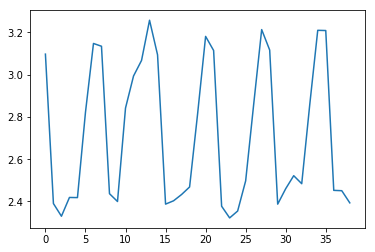

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.881226   
air_0164b9927d20bcc3_2017-04-23              1.344051   
air_0241aa3964b7f861_2017-04-23              2.374689   
air_0328696196e46f18_2017-04-23              2.028993   
air_034a3d5b40d5b1b1_2017-04-23              3.447371   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.561544  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.834545  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.747674  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.606427  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.417699

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l2_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')